# Proyecto  – Verificación Arquitectónica Ecommerce

Simulación de evolución arquitectónica frente a tráfico no controlado y estrategias de escalamiento.

## Objetivo General
Evaluar cómo tacticas como rate limiting y load balancing permiten mejorar escalabilidad y resiliencia.

## Modelado de la arquitectura inicial

###🧩 Modelado del sistema

Se modeló una arquitectura de microservicios orientada al dominio del comercio electrónico, representando explícitamente las capas de presentación, acceso, lógica de negocio, mensajería y persistencia. Los componentes definidos incluyen:

*   Frontend (ecommerce_fe)
*   API Gateway (ecommerce_ag_us)
*   Load Balancer (ecommerce_lb)
*   Backends especializados (ecommerce_be_usr, ecommerce_be_or, ecommerce_be_pd, ecommerce_be_inv)
*   Servicio de pagos con mensajería (ecommerce_be_pmt, ecommerce_be_pmt_rep)
*   Bases de datos por dominio


In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import threading, time, random
from collections import defaultdict


# Componentes: nombre → tipo
component_types = {
    "ecommerce_fe": "frontend",
    "ecommerce_be_usr": "backend",
    "ecommerce_be_or": "backend",
    "ecommerce_be_pd": "backend",
    "ecommerce_be_inv": "backend",
    "ecommerce_be_pmt": "mqtp",
    "ecommerce_be_pmt_rep": "mqtp",
    "ecommerce_ag_us": "api_gateway",
    "ecommerce_lb": "load_balancer",
    "ecommerce_be_usr_db": "database",
    "ecommerce_be_or_db": "database",
    "ecommerce_be_pd_db": "database",
    "ecommerce_be_inv_db": "database",
    "ecommerce_be_pmt_db": "database"
}

# Conectores
connectors = [
    ("ecommerce_fe", "ecommerce_ag_us", "http"),
    ("ecommerce_ag_us", "ecommerce_lb", "http"),
    ("ecommerce_lb", "ecommerce_be_usr", "http"),
    ("ecommerce_lb", "ecommerce_be_or", "http"),
    ("ecommerce_lb", "ecommerce_be_pd", "http"),
    ("ecommerce_lb", "ecommerce_be_inv", "http"),
    ("ecommerce_lb", "ecommerce_be_pmt", "http"),
    ("ecommerce_be_pmt", "ecommerce_be_pmt_rep", "mq_connector"),
    ("ecommerce_be_usr", "ecommerce_be_usr_db", "db_connector"),
    ("ecommerce_be_or", "ecommerce_be_or_db", "db_connector"),
    ("ecommerce_be_pd", "ecommerce_be_pd_db", "db_connector"),
    ("ecommerce_be_inv", "ecommerce_be_inv_db", "db_connector"),
    ("ecommerce_be_pmt", "ecommerce_be_pmt_db", "db_connector"),
]




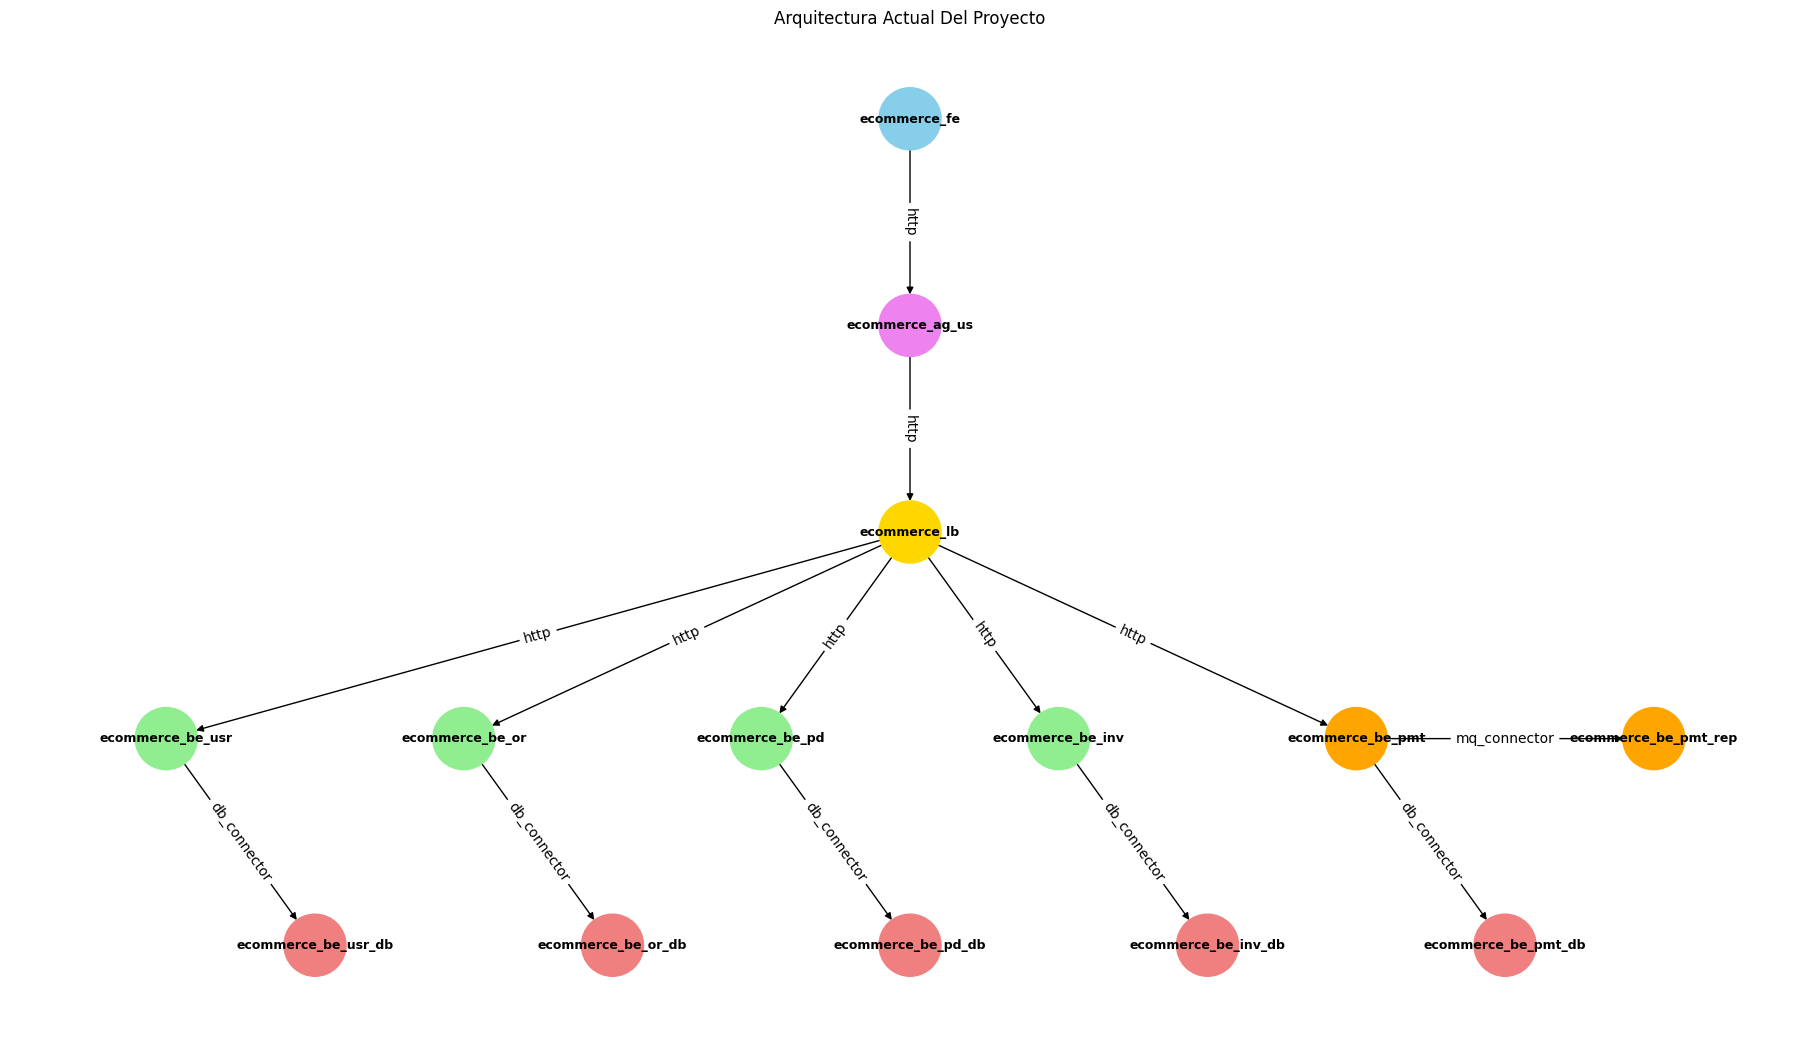

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Crear grafo dirigido
G = nx.DiGraph()

# Agregar nodos con tipo
for name, ctype in component_types.items():
    G.add_node(name, type=ctype)

# Agregar aristas con tipo de conector
for src, dst, conn_type in connectors:
    G.add_edge(src, dst, type=conn_type)

# Colores por tipo de componente
color_map = {
    'frontend': 'skyblue',
    'backend': 'lightgreen',
    'mqtp': 'orange',
    'api_gateway': 'violet',
    'load_balancer': 'gold',
    'database': 'lightcoral'
}
node_colors = [color_map.get(component_types[n], 'gray') for n in G.nodes()]


# Organizar posiciones manualmente por tipo
positions = {}
x_offsets = defaultdict(int)
y_spacing = 1.5
x_spacing = 2.5


# Agrupar nodos por capa (tipo)
layer_map = {
    "frontend": 0,
    "api_gateway": 1,
    "load_balancer": 2,
    "backend": 3,
    "mqtp": 3,
    "mqtp_rep": 4,
    "database": 4
}

# Crear diccionario: capa → [nodos]
layer_nodes = defaultdict(list)
for node in G.nodes():
    tipo = component_types[node]
    layer = layer_map.get(tipo, 4)
    layer_nodes[layer].append(node)

# Posiciones centradas por capa
positions = {}
y_spacing = 2.0
x_spacing = 2.5

for layer, nodes_in_layer in layer_nodes.items():
    count = len(nodes_in_layer)
    x_start = -(count - 1) * x_spacing / 2
    for i, node in enumerate(nodes_in_layer):
        x = x_start + i * x_spacing
        y = -layer * y_spacing
        positions[node] = (x, y)

# Graficar grafo centrado por capas
plt.figure(figsize=(18, 10))
nx.draw(G, positions, with_labels=True, node_color=node_colors,
        node_size=2000, font_size=9, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G, positions,
        edge_labels={(u, v): d['type'] for u, v, d in G.edges(data=True)})

plt.title("Arquitectura Actual Del Proyecto")
plt.axis('off')
plt.show()


## 🔥 Iteración 1 – Simulación de Ataque DDoS (sin rate limit)

Se simula un escenario donde el sistema recibe **N** solicitudes concurrentes, sin ningún tipo de protección o control de entrada. Cada solicitud sigue una ruta aleatoria desde el frontend hasta una base de datos.

In [57]:
import threading
import time
import random
from collections import Counter

# ---------------------------
# Clase para simular un componente con capacidad
# ---------------------------

class Component:
    def __init__(self, name, capacity=100):
        self.name = name
        self.capacity = capacity
        self.lock = threading.Lock()
        self.current_load = 0

    def process(self):
        with self.lock:
            if self.current_load >= self.capacity:
                return False
            self.current_load += 1
        time.sleep(random.uniform(0.005, 0.015))
        with self.lock:
            self.current_load -= 1
        return True


component_objects = {}


for name, ctype in component_types.items():
    cap = 10 if ctype in ['api_gateway', 'load_balancer', 'backend', 'mqtp'] else 80
    component_objects[name] = Component(name, cap)
    G.add_node(name, type=ctype)


#### Simulación de una transacción desde el frontend a una database

Resumen de transacciones:
Counter({'Failed': 699, 'Success': 301})

Fallos por componente:
Counter({'ecommerce_ag_us': 661, 'ecommerce_lb': 38})


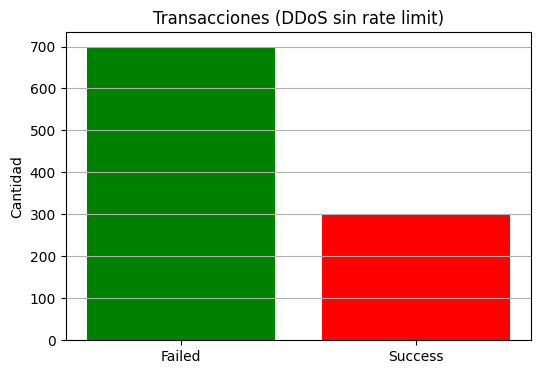

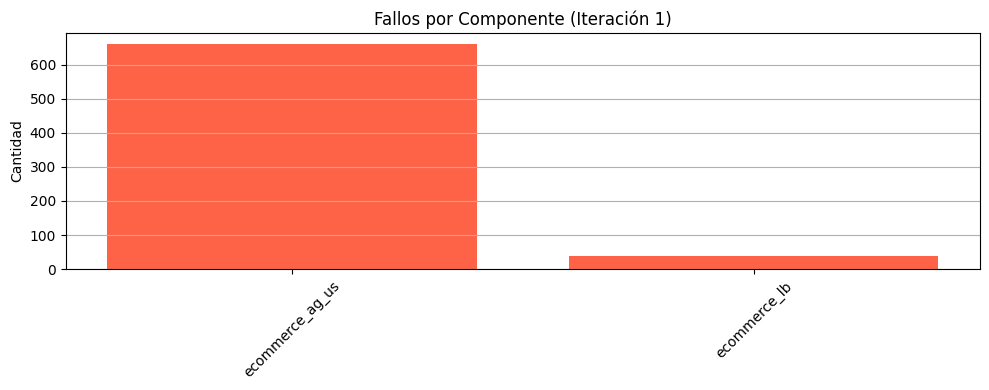

In [58]:
# ---------------------------
# Simulación de una transacción desde frontend a un database
# ---------------------------
def simulate_transaction_ddos(result_list):
    try:
        start = "ecommerce_fe"
        targets = [n for n in G.nodes() if component_types[n] == "database"]
        end = random.choice(targets)
        path = nx.shortest_path(G, source=start, target=end)
    except:
        result_list.append(("Failed", "No path"))
        return

    for node in path:
        if not component_objects[node].process():
            result_list.append(("Failed", node))
            return
    result_list.append(("Success", None))

# ---------------------------
# Ejecutar DDoS – 1000 solicitudes simultáneas
# ---------------------------
results_ddos = []
threads = []

for _ in range(1000):  # CAMBIAR VALOR PARA GENERAR MAYOR TRAFICO.
    t = threading.Thread(target=simulate_transaction_ddos, args=(results_ddos,))
    threads.append(t)
    t.start()

for t in threads:
    t.join()

summary_ddos = Counter([r[0] for r in results_ddos])
fail_by_component_ddos = Counter([r[1] for r in results_ddos if r[0] == "Failed"])

print("Resumen de transacciones:")
print(summary_ddos)
print("\nFallos por componente:")
print(fail_by_component_ddos)


# ---------------------------
# Gráfica de resultados
# ---------------------------
plt.figure(figsize=(6, 4))
plt.bar(summary_ddos.keys(), summary_ddos.values(), color=["green", "red"])
plt.title("Transacciones (DDoS sin rate limit)")
plt.ylabel("Cantidad")
plt.grid(axis='y')
plt.show()
print("\n")
plt.figure(figsize=(10, 4))
plt.bar(fail_by_component_ddos.keys(), fail_by_component_ddos.values(), color="tomato")
plt.title("Fallos por Componente (Iteración 1)")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## 🛡️ Iteración 2 – Mitigación con Rate Limiting


En esta iteración se introduce una mejora arquitectónica destinada a mitigar los efectos de un ataque de denegación de servicio (DDoS), observado en la Iteración 1. El principal cambio consiste en la incorporación de un mecanismo de rate limiting sobre la capa de acceso (API Gateway), con el objetivo de controlar la cantidad de transacciones que pueden ser procesadas de forma concurrente por el sistema.

In [59]:
# ---------------------------
# Implementación de RateLimiter
# ---------------------------

class RateLimiter:
    def __init__(self, max_concurrent):
        self.semaphore = threading.Semaphore(max_concurrent)

    def acquire(self):
        return self.semaphore.acquire(blocking=False)

    def release(self):
        self.semaphore.release()

In [60]:
# ---------------------------
# Simulación del flujo de RateLimiter
# ---------------------------


def simulate_transaction_ratelimited(result_list, rate_limiter):
    if not rate_limiter.acquire():
        result_list.append(("Rejected", "RateLimited"))
        return

    try:
        start = "ecommerce_fe"
        targets = [n for n in G.nodes() if component_types[n] == "database"]
        end = random.choice(targets)
        path = nx.shortest_path(G, source=start, target=end)
    except:
        result_list.append(("Failed", "No path"))
        rate_limiter.release()
        return

    for node in path:
        if not component_objects[node].process():
            result_list.append(("Failed", node))
            rate_limiter.release()
            return

    result_list.append(("Success", None))
    rate_limiter.release()

In [61]:
# ---------------------------
# Configuración del RateLimiter
# ---------------------------

rate_limiter = RateLimiter(max_concurrent=30)
results_limited = []
threads_limited = []

for _ in range(1000):
    t = threading.Thread(target=simulate_transaction_ratelimited, args=(results_limited, rate_limiter))
    threads_limited.append(t)
    t.start()

for t in threads_limited:
    t.join()

summary_limited = Counter([r[0] for r in results_limited])
fail_by_component_limited = Counter([r[1] for r in results_limited if r[0] == "Failed"])

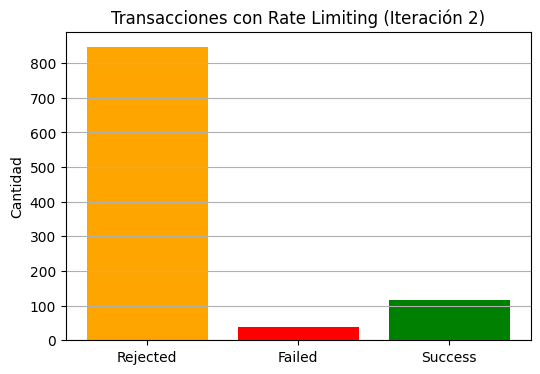

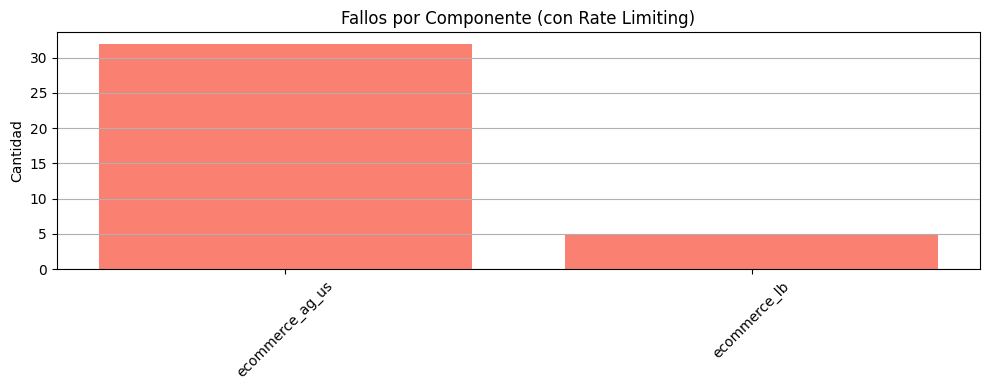

In [62]:
# ---------------------------
# Graficas con resultados.
# ---------------------------

plt.figure(figsize=(6, 4))
plt.bar(summary_limited.keys(), summary_limited.values(), color=["orange", "red", "green"])
plt.title("Transacciones con Rate Limiting (Iteración 2)")
plt.ylabel("Cantidad")
plt.grid(axis='y')
plt.show()
print("\n")
plt.figure(figsize=(10, 4))
plt.bar(fail_by_component_limited.keys(), fail_by_component_limited.values(), color="salmon")
plt.title("Fallos por Componente (con Rate Limiting)")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## ♨️ Iteración 3 – Simulación de sobrecarga del sistema (sin escalabilidad)

Se simula un escenario donde el sistema recibe **X** número de solicitudes, sin ningún tipo escalamiento horizontal por defecto. Cuando un componente alcanza el limite máximo de peticiones permitidas y comienza a rechazarlas, este no es escalado automáticamente mediante la creación de nuevas replicas de instancias de este, generando un colapso en el sistema, siendo este 0% resiliente.

In [ ]:
import threading
import time
import random
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------
# Reutilización de la clase Component (con capacidades más bajas para simular saturación más fácil)
# ---------------------------
class Component:
    def __init__(self, name, capacity=5):  # Reducimos la capacidad para simular la saturación más rápido
        self.name = name
        self.capacity = capacity
        self.lock = threading.Lock()
        self.current_load = 0

    def process(self):
        with self.lock:
            if self.current_load >= self.capacity:
                return False
            self.current_load += 1
        time.sleep(random.uniform(0.005, 0.015))
        with self.lock:
            self.current_load -= 1
        return True

# ---------------------------
# Re-inicialización de los objetos Component con la capacidad reducida
# ---------------------------
component_objects = {}
for name, ctype in component_types.items():
    cap = 5 if ctype in ['api_gateway', 'load_balancer', 'backend', 'mqtp'] else 20 # Capacidad aún menor para las DB
    component_objects[name] = Component(name, cap)
    G.add_node(name, type=ctype)

# ---------------------------
# Simulación de una transacción (sin Rate Limiter para observar la saturación interna)
# ---------------------------
def simulate_transaction_overload(result_list):
    try:
        start = "ecommerce_fe"
        targets = [n for n in G.nodes() if component_types[n] == "database"]
        end = random.choice(targets)
        path = nx.shortest_path(G, source=start, target=end)
    except:
        result_list.append(("Failed", "No path"))
        return

    for node in path:
        if not component_objects[node].process():
            result_list.append(("Failed", node))
            return
    result_list.append(("Success", None))

# ---------------------------
# Ejecutar Simulación de Sobrecarga - Aumento significativo de solicitudes
# ---------------------------
num_requests_overload = 2000  # Aumentamos significativamente el número de solicitudes
results_overload = []
threads_overload = []

print(f"Iniciando simulación de sobrecarga con {num_requests_overload} solicitudes...")

for _ in range(num_requests_overload):
    t = threading.Thread(target=simulate_transaction_overload, args=(results_overload,))
    threads_overload.append(t)
    t.start()

for t in threads_overload:
    t.join()

summary_overload = Counter([r[0] for r in results_overload])
fail_by_component_overload = Counter([r[1] for r in results_overload if r[0] == "Failed"])

Iniciando simulación de sobrecarga con 2000 solicitudes...


In [ ]:
# ---------------------------
# Gráficas y resultados (Sobrecarga sin escalabilidad)
# ---------------------------

print("\nResumen de transacciones (Sobrecarga sin escalabilidad):")
print(summary_overload)
print("\nFallos por componente (Sobrecarga sin escalabilidad):")
print(fail_by_component_overload)

plt.figure(figsize=(6, 4))
plt.bar(summary_overload.keys(), summary_overload.values(), color=["red", "green"])
plt.title(f"Transacciones (Sobrecarga - {num_requests_overload} solicitudes)")
plt.ylabel("Cantidad")
plt.grid(axis='y')
plt.show()
print("\n")
plt.figure(figsize=(10, 4))
plt.bar(fail_by_component_overload.keys(), fail_by_component_overload.values(), color="tomato")
plt.title("Fallos por Componente (Sobrecarga sin escalabilidad)")
plt.ylabel("Cantidad")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

print("\nSimulación de sobrecarga completada. Observa el alto número de fallos y qué componentes se saturaron primero.")
print("Esto demuestra la falta de resiliencia del sistema ante una carga no controlada sin escalabilidad.")

### ✅ Iteración 4 – Mitigación con Autoscaling


Después de evidenciar el problema actual del sistema, se decide implementar una técnica de autoescalado para los componentes backend, esto con el fin de que nuevas instancias replicas de un componente saturado sean levantadas para que el balanceador distribuya carga uniformemente y de esta forma el sistema pueda responder al tener una alta disponibilidad y resiliencia.

In [ ]:
import threading
import time
import random
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------
# Clase Component con soporte para escalado
# ---------------------------
class ScalableComponent:
    def __init__(self, name, base_capacity=2, scale_factor=5, threshold=0.4, cooldown=0.05):
        self.name = name
        self.base_capacity = base_capacity
        self.current_capacity = base_capacity
        self.scale_factor = scale_factor
        self.threshold = threshold  # Umbral de escalado
        self.cooldown = cooldown    # Tiempo de enfriamiento
        self.last_scaled = 0
        self.lock = threading.Lock()
        self.current_load = 0
        self.instance_count = 1
        self.is_scaling = False
        self.process_delay = random.uniform(0.001, 0.003) # Simular procesamiento más rápido

    def process(self):
        with self.lock:
            if self.current_load >= self.current_capacity:
                return False
            self.current_load += 1
        time.sleep(self.process_delay)
        with self.lock:
            self.current_load -= 1
        return True

    def check_and_scale(self):
        with self.lock:
            if not self.is_scaling and self.current_load / self.current_capacity > self.threshold and (time.time() - self.last_scaled) > self.cooldown:
                self._scale_up()

    def _scale_up(self):
        self.is_scaling = True
        print(f"Escalando componente: {self.name}. Instancia actual: {self.instance_count}, Nueva capacidad: {int(self.current_capacity * self.scale_factor)}")
        self.current_capacity *= self.scale_factor
        self.instance_count += 1
        self.last_scaled = time.time()
        self.is_scaling = False

# ---------------------------
# Inicialización de los componentes escalables (solo backends)
# ---------------------------
scalable_component_objects = {}
for name, ctype in component_types.items():
    if ctype == 'backend':
        scalable_component_objects[name] = ScalableComponent(name)
    else:
        capacity = 50 if ctype in ['api_gateway', 'load_balancer', 'mqtp'] else 100
        scalable_component_objects[name] = ScalableComponent(name, base_capacity=capacity, threshold=1.0) # No escalar otros componentes

# ---------------------------
# Simulación de transacción con autoescalado
# ---------------------------
def simulate_transaction_autoscaling(result_list):
    try:
        start = "ecommerce_fe"
        targets = [n for n in G.nodes() if component_types[n] == "database"]
        end = random.choice(targets)
        path = nx.shortest_path(G, source=start, target=end)
    except:
        result_list.append(("Failed", "No path"))
        return

    for node in path:
        component = scalable_component_objects.get(node)
        if component:
            if not component.process():
                result_list.append(("Failed", node))
                return
            if isinstance(component, ScalableComponent):
                component.check_and_scale() # Verificar escalado en backends
        else:
            time.sleep(random.uniform(0.001, 0.003))

    result_list.append(("Success", None))

In [ ]:
# ---------------------------
# Ejecutar Simulación con Autoscaling
# ---------------------------
num_requests_autoscaling = 2000 # Mantener el mismo número de solicitudes
results_autoscaling = []
threads_autoscaling = []

print(f"Iniciando simulación con autoescalado...")

for _ in range(num_requests_autoscaling):
    t = threading.Thread(target=simulate_transaction_autoscaling, args=(results_autoscaling,))
    threads_autoscaling.append(t)
    t.start()

for t in threads_autoscaling:
    t.join()

summary_autoscaling = Counter([r[0] for r in results_autoscaling])
fail_by_component_autoscaling = Counter([r[1] for r in results_autoscaling if r[0] == "Failed"])

if "Failed" not in summary_autoscaling:
    summary_autoscaling["Failed"] = 0

transaction_order = ["Failed", "Success"]
ordered_summary = {}
for key in transaction_order:
    ordered_summary[key] = summary_autoscaling.get(key, 0)

In [ ]:
# ---------------------------
# Gráficas y resultados (con Autoscaling)
# ---------------------------
print("\nResumen de transacciones:")
print(summary_autoscaling)
print("\nFallos por componente:")
print(fail_by_component_autoscaling)

plt.figure(figsize=(6, 4))
labels = list(ordered_summary.keys())
values = list(ordered_summary.values())
plt.bar(labels, values, color=["lightcoral", "forestgreen"])
plt.title(f"Transacciones ({num_requests_autoscaling} solicitudes)")
plt.ylabel("Cantidad")
plt.grid(axis='y')
plt.show()
print("\n")
plt.figure(figsize=(10, 4))
plt.bar(fail_by_component_autoscaling.keys(), fail_by_component_autoscaling.values(), color="seagreen")
plt.title("Fallos por Componente")
plt.ylabel("Cantidad")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

print("\nSimulación con autoescalado completada.")